## Caution: important experiment, please do not adjust

The contents within this file are for running a publication-quality experiment and producing the associated figures and results. As such, it is finely tuned for specific high-quality graphics using the `primary.mplstyle` file. Please do not adjust. If you need to replicate results on your local system, please create a new notebook and copy contents from here.

# Landscape Detection with Generic Reconstructions

In this experiment, the ability for various reconstruction-based algorithms to rank landscapes containing novel content is investigated.

In [8]:
import sys
sys.path.append('../..')  # Expose top level program access

import time
import pickle
import logging
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from functools import reduce
from pathlib import Path

from modules.cae_base_module import CAEBaseModule
from modules.vae_base_module import VAEBaseModule
from modules.aae_base_module import AAEBaseModule
from modules.pca_base_module import PCABaseModule
from models import supported_models
from datasets import supported_datamodules
from utils import tools, metrics, supported_preprocessing_transforms
from utils.dtypes import *

logging.getLogger("matplotlib").setLevel(logging.WARNING)  # Suppress verbose font warnings from matplotlib

In [2]:
# Import configurations and paths to logged models
root = Path.cwd().parents[1]
log_path = root / 'logs' / 'LunarAnalogueDataModule'
paths_to_archived_models = list(Path(log_path).glob('**/archive_v*'))

print('Found archived models:\n------')
print('\n'.join([f'{p.parent.name}/{p.name}' for p in paths_to_archived_models]))

Found archived models:
------
BaselineVAE/archive_v2_2021-05-06
BaselineVAE/archive_v1_2021-05-06
BaselineCAE/archive_v3_2021-05-06
BaselineCAE/archive_v2_2021-05-06
BaselineCAE/archive_v1_2021-04-12
BaselineAAE/archive_v1_2021-05-06


In [3]:
from experiments.helpers import load_modules

module_catalog, datamodule, _ = load_modules(paths_to_archived_models)

Loading state dict for: BaselineVAE/archive_v2_2021-05-06
Loading state dict for: BaselineVAE/archive_v1_2021-05-06
Loading state dict for: BaselineCAE/archive_v3_2021-05-06
Loading state dict for: BaselineCAE/archive_v2_2021-05-06
Loading state dict for: BaselineCAE/archive_v1_2021-04-12
Loading state dict for: BaselineAAE/archive_v1_2021-05-06


In [4]:
# Collect scores and labels on test set for all models and save to a dictionary
result_catalog = {}

for model_type, model_variants in module_catalog.items():
    start_time = time.time()
    
    for model_name, module in model_variants.items():
        
        test_novelty_scores = []
        test_novelty_labels = []
        short_name = model_type + '-' + model_name.split('_')[1]
        if short_name not in result_catalog:
            result_catalog[short_name] = {
                'scores': [], 
                'labels': []
            }
        print(f'------\n{short_name}\n------')
        
        # Handle the PCA and autoencoder frameworks separately
        if 'PCA' in short_name:
            test_novelty_scores = module.transform_pipeline(datamodule)
            test_novelty_labels = pca_test_labels
        else:
        
            # Set the model/components in evaluation mode
            if 'AAE' in model_type:
                module.encoder.eval()
                module.decoder.eval()
            else:
                module.model.eval()
        
            with torch.no_grad():
                for batch_nb, batch in enumerate(datamodule.test_dataloader()):

                    result = module.test_step(batch, batch_nb)

                    test_novelty_scores.extend(result['scores'])
                    test_novelty_labels.extend(result['labels'].cpu().numpy())
                    print(f'[BATCH {batch_nb}] Mean score: {np.mean(result["scores"])}')
                    
        result_catalog[short_name]['scores'] = test_novelty_scores
        result_catalog[short_name]['labels'] = test_novelty_labels
        print(f'{short_name} Time: {time.time() - start_time:.2f} s\n')

------
BaselineVAE-v2
------
[BATCH 0] Mean score: 0.6611186265945435
[BATCH 1] Mean score: 0.6401923894882202
[BATCH 2] Mean score: 0.6703945398330688
[BATCH 3] Mean score: 0.6442825794219971
[BATCH 4] Mean score: 0.684728741645813
[BATCH 5] Mean score: 0.6556631922721863
[BATCH 6] Mean score: 0.6092772483825684
[BATCH 7] Mean score: 0.6406859159469604
[BATCH 8] Mean score: 0.7238338589668274
[BATCH 9] Mean score: 0.6876003742218018
[BATCH 10] Mean score: 0.6870328187942505
[BATCH 11] Mean score: 0.6792194843292236
[BATCH 12] Mean score: 0.680462121963501
[BATCH 13] Mean score: 0.6998332738876343
[BATCH 14] Mean score: 0.7113326787948608
[BATCH 15] Mean score: 0.7005208730697632
[BATCH 16] Mean score: 0.6936811804771423
[BATCH 17] Mean score: 0.6513900756835938
[BATCH 18] Mean score: 0.6612129807472229
[BATCH 19] Mean score: 0.6761833429336548
[BATCH 20] Mean score: 0.7172629833221436
[BATCH 21] Mean score: 0.7094718813896179
[BATCH 22] Mean score: 0.7040768265724182
[BATCH 23] Mean s

BaselineVAE-v2: 566.239501953125
BaselineVAE-v1: 581.9212646484375
BaselineCAE-v3: 87.26337432861328
BaselineCAE-v2: 93.74098205566406
BaselineCAE-v1: 89.07831573486328
BaselineAAE-v1: 267.5571594238281


2021-05-21 16:20:10,086 - WARNING - findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
2021-05-21 16:20:10,118 - WARNING - findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
2021-05-21 16:20:10,873 - DEBUG - STREAM b'IHDR' 16 13
2021-05-21 16:20:10,874 - DEBUG - STREAM b'PLTE' 41 48
2021-05-21 16:20:10,875 - DEBUG - STREAM b'tRNS' 101 15
2021-05-21 16:20:10,875 - DEBUG - STREAM b'pHYs' 128 9
2021-05-21 16:20:10,876 - DEBUG - STREAM b'IDAT' 149 96
2021-05-21 16:20:10,879 - DEBUG - STREAM b'IHDR' 16 13
2021-05-21 16:20:10,880 - DEBUG - STREAM b'PLTE' 41 48
2021-05-21 16:20:10,880 - DEBUG - STREAM b'tRNS' 101 15
2021-05-21 16:20:10,881 - DEBUG - STREAM b'pHYs' 128 9
2021-05-21 16:20:10,881 - DEBUG - STREAM b'IDAT' 149 129
2021-05-21 16:20:10,884 - DEBUG - STREAM b'IHDR' 16 13
2021-05-21 16:20:10,884 - DEBUG - STREAM b'PLTE' 41 48
2021-05-21 16:20:10,885 - DEBUG - STREAM b'tRNS' 101 15
2021-05-21 16:20:10,885 - DEBUG - STREAM b'pHYs' 128 9
2021-05-

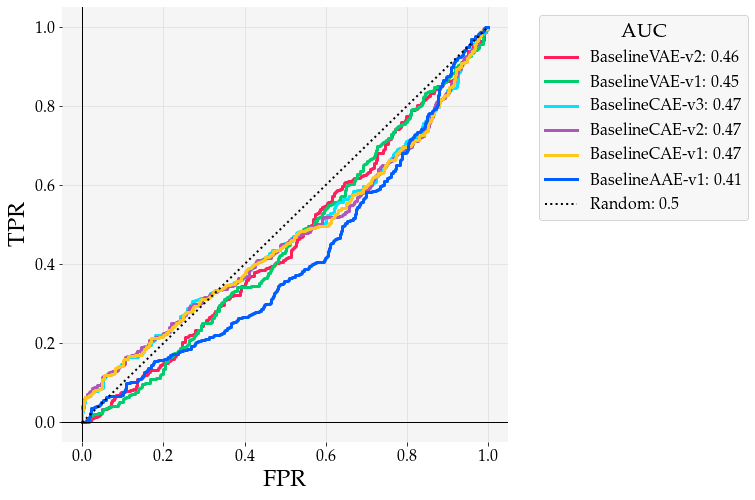

Random ROC AUC: 0.5


In [5]:
# Use standard custom styling
plt.style.use('../../utils/_extras/primary.mplstyle')

# Plot the ROC curves with AUCs for each model
fig, ax = plt.subplots(figsize=(8, 8))
for sn, results in result_catalog.items():

    scores = results['scores']
    labels = results['labels']
    print(f'{sn}: {sum(scores)}')
    
    fpr, tpr, thresholds, auc = metrics.roc(scores, labels)
    
    ax.plot(fpr, tpr, label=f'{sn}: {auc:.2f}')
    
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.plot([0., 1.], [0., 1.], 'k:', lw=2, label='Random: 0.5')
ax.legend(title='AUC', bbox_to_anchor=(1.05, 1.), loc='upper left')

ax.axhline(0, 0, c='k', lw=1)
ax.axvline(0, 0, c='k', lw=1)

plt.savefig('ROC-all_LunarAnalogueLandscape.pdf', format='pdf', bbox_inches='tight')
plt.show()
print('Random ROC AUC: 0.5')

2021-05-21 16:20:12,962 - DEBUG - STREAM b'IHDR' 16 13
2021-05-21 16:20:12,963 - DEBUG - STREAM b'PLTE' 41 48
2021-05-21 16:20:12,964 - DEBUG - STREAM b'tRNS' 101 15
2021-05-21 16:20:12,964 - DEBUG - STREAM b'pHYs' 128 9
2021-05-21 16:20:12,965 - DEBUG - STREAM b'IDAT' 149 398
2021-05-21 16:20:12,967 - DEBUG - STREAM b'IHDR' 16 13
2021-05-21 16:20:12,968 - DEBUG - STREAM b'PLTE' 41 48
2021-05-21 16:20:12,968 - DEBUG - STREAM b'tRNS' 101 15
2021-05-21 16:20:12,969 - DEBUG - STREAM b'pHYs' 128 9
2021-05-21 16:20:12,969 - DEBUG - STREAM b'IDAT' 149 156
2021-05-21 16:20:12,972 - DEBUG - STREAM b'IHDR' 16 13
2021-05-21 16:20:12,972 - DEBUG - STREAM b'PLTE' 41 48
2021-05-21 16:20:12,973 - DEBUG - STREAM b'tRNS' 101 15
2021-05-21 16:20:12,973 - DEBUG - STREAM b'pHYs' 128 9
2021-05-21 16:20:12,973 - DEBUG - STREAM b'IDAT' 149 109
2021-05-21 16:20:12,989 - DEBUG - STREAM b'IHDR' 16 13
2021-05-21 16:20:12,989 - DEBUG - STREAM b'PLTE' 41 48
2021-05-21 16:20:12,990 - DEBUG - STREAM b'tRNS' 101 15


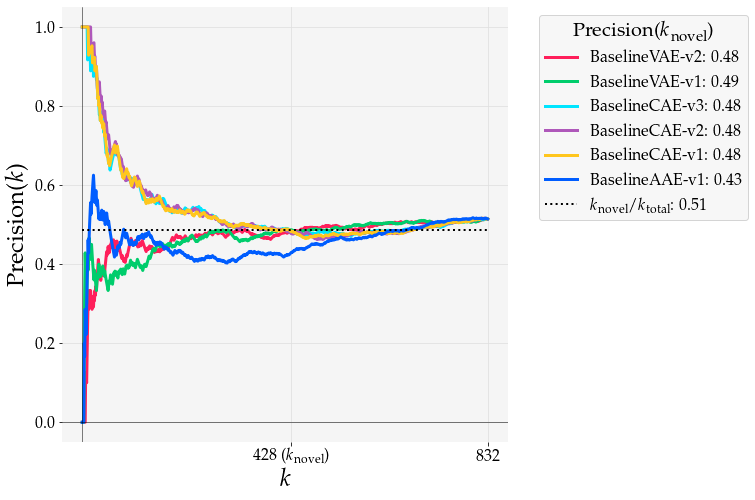

In [6]:
# Plot the Precision(k) across all test images.
fig, ax = plt.subplots(figsize=(8, 8))
for sn, results in result_catalog.items():
    
    scores = results['scores']
    labels = results['labels']
    pak = metrics.precision_at_k(scores, labels)

    uniques, counts = np.unique(labels, return_counts=True)
    random = counts.min() / counts.sum()

    ax.plot(pak, label=f'{sn}: {pak[int(sum(labels))]:.2f}')
    
ax.plot([0, len(pak)], [random, random], 'k:', lw=2, 
        label='$k_{\mathrm{novel}}/k_{\mathrm{total}}$: '+f'{counts[1]/counts.sum():.2f}')

ax.set_xlabel('$k$')
ax.set_ylabel('Precision($k$)')
ax.legend(title='Precision($k_{\mathrm{novel}}$)', bbox_to_anchor=(1.05, 1.), loc='upper left')

ax.set_xticks([counts[1], counts.sum()])
ax.set_xticklabels([str(counts[1])+' ($k_{\mathrm{novel}}$)', counts.sum()])

# Draw axes for styling
ax.axhline(0, 0, c='k', lw=0.5)
ax.axvline(0, 0, c='k', lw=0.5)

plt.savefig('Pak-all_LunarAnalogueLandscape.pdf', format='pdf', bbox_inches='tight')
plt.show()

BaselineVAE-v2


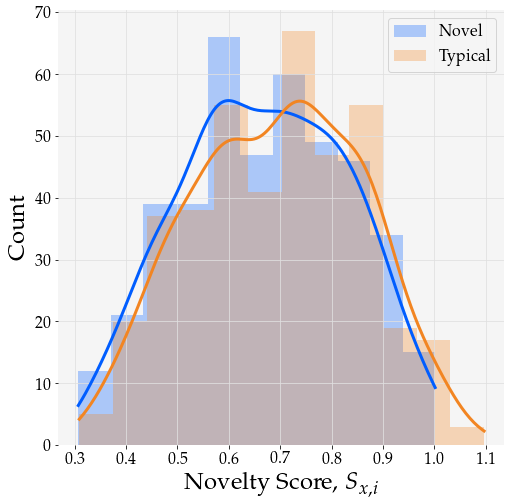

BaselineVAE-v1


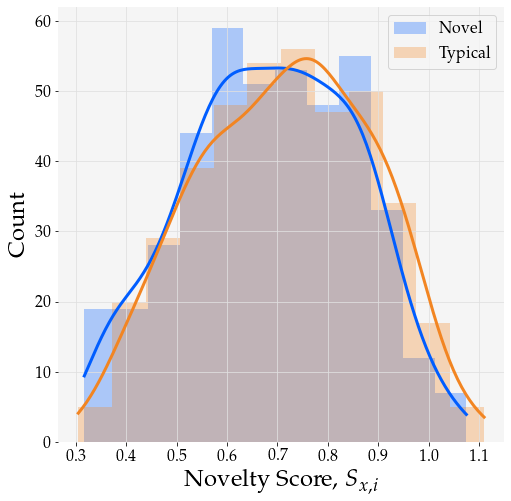

BaselineCAE-v3


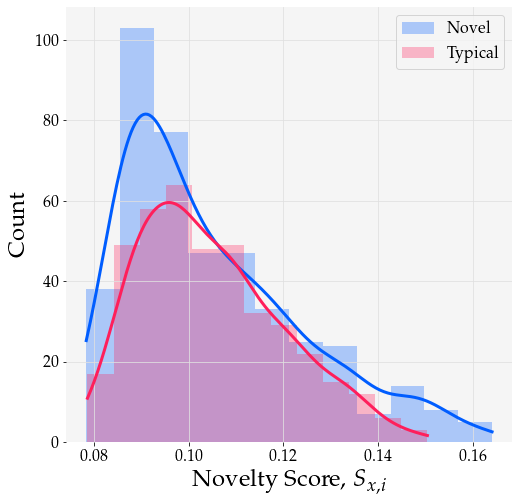

BaselineCAE-v2


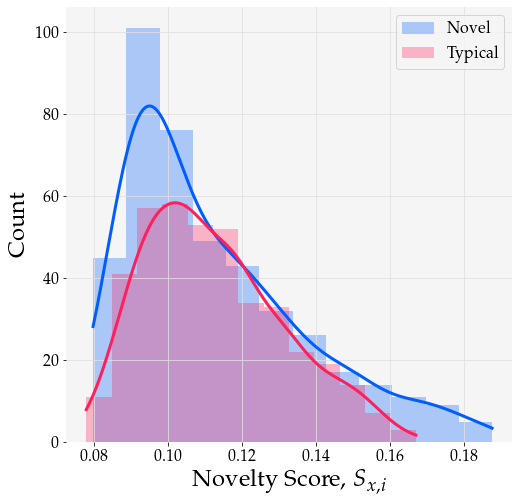

BaselineCAE-v1


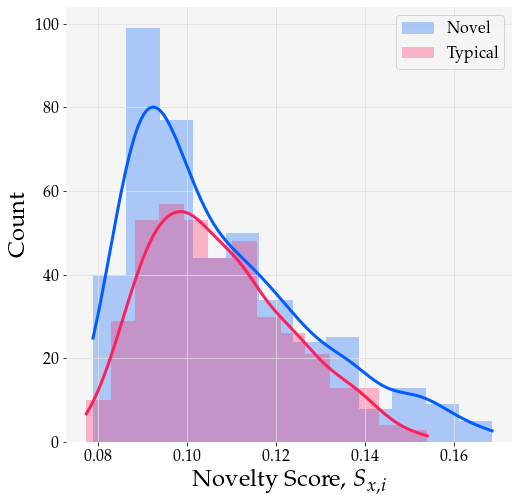

BaselineAAE-v1


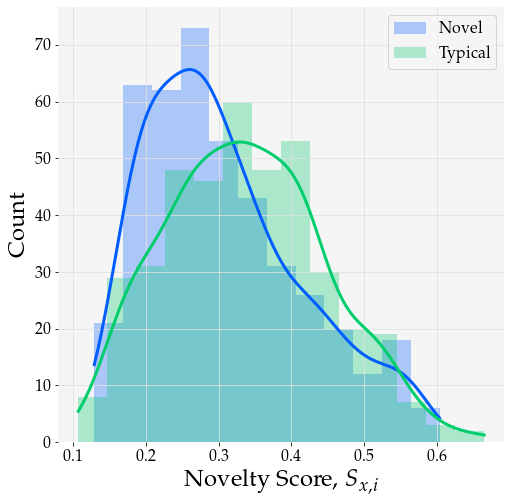

In [10]:
def score_density_vis_rc(rc_scores, labels, sn, color='C1'):
    
    labels = np.array(labels).astype(bool)
    rc_scores = np.array(rc_scores)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.histplot(data=rc_scores[labels], label='Novel', color='C5', fill=True, lw=0, alpha=0.3, kde=True)
    sns.histplot(data=rc_scores[~labels], label='Typical', color=color, fill=True, lw=0, alpha=0.3, kde=True)
    ax.set_xlabel('Novelty Score, $S_{x,i}$')
    plt.legend()
    plt.savefig(f'ReconstructionScoreDensity-{sn}-CuriosityMastcam.pdf', format='pdf', bbox_inches='tight')
    plt.show()

for sn, res in result_catalog.items():
    print(sn)
            
    rc_scores = res['scores']
    if 'AAE' in sn:
        color = 'C1'
    elif 'VAE' in sn:
        color = 'C6'
    else:
        color = 'C0'
    score_density_vis_rc(rc_scores, res['labels'], sn, color=color)